# Sentiment analysis

Author: **Rafael Ito**  
e-mail: ito.rafael@gmail.com

## 0. Dataset and Description

**Name:**  IMDb  
**Description:** this notebook uses the IMDb dataset which contains movie reviews classified as either positive or negative review. The aim is to perform a supervised learning for sentiment classification.

## 1. Libraries and packages

### 1.1 Install packages

In [0]:
!pip install -q \
    numpy       \
    torch       \
    sklearn     \
    skorch      \
    matplotlib  

### 1.2 Import libraries

In [0]:
#-------------------------------------------------
# general
#-------------------
import numpy as np
import pandas as pd
import re
#-------------------------------------------------
# PyTorch
#-------------------
import torch
from torch.utils.data import TensorDataset
import torch.nn.functional as F
#-------------------------------------------------
# skorch
#-------------------
#from skorch import NeuralNetClassifier
#-------------------------------------------------
# scikit-learn
#-------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
#-------------------------------------------------
# data visualization
#-------------------
import matplotlib.pyplot as plt
import seaborn as sns
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
torch.manual_seed(42);

### 1.3 Check device

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('Device:', device)

Device: cuda


### 1.4 Function to plot confusion matrix

In [0]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, title=None, normalize=False, cmap=plt.cm.Blues, figsize = (10,7), fontsize=14):
    # normalized or raw CM
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    #----------------------------
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt, cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    #----------------------------
    # fix matplotlib 3.1.1 bug
    #heatmap.get_ylim() --> (5.5, 0.5)
    #heatmap.set_ylim(6.0, 0)
    #----------------------------
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

## 2. Dataset

### 2.1 Download

In [5]:
# download dataset
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

File ‘imdb_sample.tgz’ already there; not retrieving.



### 2.2 Dataset preparation

In [0]:
# read csv spreadsheet
df = pd.read_csv('imdb_sample/texts.csv')

Input

In [0]:
# getting only the 'text' column as a list
corpus = df['text'].tolist()

In [0]:
# scikit-learn
vectorizer = CountVectorizer()
X_sparse = vectorizer.fit_transform(corpus)
vocab = vectorizer.get_feature_names()

In [0]:
X = torch.tensor(X_sparse.toarray(), dtype=torch.float32)

Target

In [0]:
# Pandas
target_pd = df['label']
# NumPy
target_np = target_pd.to_numpy().reshape(-1,1)

In [0]:
# one-hot encoder
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
target_oh = enc.fit_transform(target_np)

In [0]:
# PyTorch
target = torch.tensor(target_oh[:,1].toarray(), dtype=torch.int64)
target = torch.squeeze(target, 1)

### 2.3 PyTorch dataset creation

In [0]:
# create dataset
ds = TensorDataset(X, target)

In [0]:
# split in training, validation and test sets
ds_train, ds_val, ds_test = torch.utils.data.random_split(ds, (600, 200, 200))

### 2.4 PyTorch loader creation

- BATCH_SIZE definition
- training dataset
- validation dataset

In [0]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_VAL   = 100
BATCH_SIZE_TEST  = 100
#-------------------------------------------------
# training data loader
dl_train = torch.utils.data.DataLoader(
              dataset=ds_train, 
              drop_last = False,
              shuffle = False,
              #batch_size = BATCH_SIZE)
              batch_size = BATCH_SIZE_TRAIN)
#-------------------------------------------------
# validation data loader
dl_val   = torch.utils.data.DataLoader(
              dataset = ds_val,
              drop_last = False,
              shuffle = False,
              #batch_size = BATCH_SIZE)
              batch_size = BATCH_SIZE_VAL)
#-------------------------------------------------
# test data loader
dl_test   = torch.utils.data.DataLoader(
              dataset = ds_test,
              drop_last = False,
              shuffle = False,
              #batch_size = BATCH_SIZE)
              batch_size = BATCH_SIZE_TEST)

### 2.5 Verifying shape, batch data type from loader and optionally its visualization

In [16]:
tx, ty = iter(dl_train).next()
print('train:', tx.shape, tx.dtype, ty.shape, ty.dtype)
tx, ty = iter(dl_val).next()
print('val:', tx.shape, tx.dtype, ty.shape, ty.dtype)
print('last batch size:', len(ds_train)%BATCH_SIZE_TRAIN, len(ds_val)%BATCH_SIZE_VAL)

train: torch.Size([100, 18668]) torch.float32 torch.Size([100]) torch.int64
val: torch.Size([100, 18668]) torch.float32 torch.Size([100]) torch.int64
last batch size: 0 0


## 3. Network Model

### 3.1 Network class definition

In [0]:
'''
L1 (1st layer): 18668 inputs, 1000 outputs
L2 (2nd layer):  1000 inputs, 1000 outputs
L3 (3rd layer):  1000 inputs,    2 outputs
'''
class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.L1 = torch.nn.Linear(in_features=18668,  out_features=10000)
        self.L1D = torch.nn.Dropout(0.5)
        self.L2 = torch.nn.Linear(in_features=10000,  out_features=1000)
        self.L2D = torch.nn.Dropout(0.5)
        self.L3 = torch.nn.Linear(in_features=1000,  out_features=2)

    def forward(self, x):
        #-------------------
        # dense layer, ReLU, dropout
        x = self.L1(x)
        x = F.relu(x)
        x = self.L1D(x)
        #-------------------
        # dense layer, ReLU, dropout
        x = self.L2(x)
        x = F.relu(x)
        x = self.L2D(x)
        #-------------------
        # dense layer
        x = self.L3(x)
        #-------------------
        return x

### 3.2 Network instantiation

In [18]:
model = NN()
model.to(device)

NN(
  (L1): Linear(in_features=18668, out_features=10000, bias=True)
  (L1D): Dropout(p=0.5, inplace=False)
  (L2): Linear(in_features=10000, out_features=1000, bias=True)
  (L2D): Dropout(p=0.5, inplace=False)
  (L3): Linear(in_features=1000, out_features=2, bias=True)
)

### 3.3 Network predict with few samples of batch from loader

In [19]:
model(ds_train[0][0].to(device))

tensor([-0.1350,  0.0137], device='cuda:0', grad_fn=<AddBackward0>)

## 4. Network training

### 4.1 Training definitions

- number of epochs
- optimizer and LR (learning rate)
- loss function


In [0]:
# Training parameters
EPOCH = 100
LR = 0.04
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=LR)
# loss history
loss_his = []
loss_val_his = []

### 4.2 Training loop

In [21]:
N_SAMPLES = len(ds_train)
for epoch in range(EPOCH):
    print('epoch =', epoch, end='; ')
    #-------------------------------------------------
    # training mode
    #-------------------
    model.train()
    score_train = 0.
    for b_i, (b_x, b_y) in enumerate(dl_train):   # for each training step
        b_x, b_y = b_x.to(device), b_y.to(device)
        y_logitos = model(b_x)
        loss = loss_func(y_logitos, b_y)
        opt.zero_grad()                 # clear gradients for next train
        loss.backward()                 # backpropagation, compute gradients
        opt.step()                      # apply gradients
        #-------------------
        y_pred = torch.argmax(y_logitos, dim=1)
        score_train += (b_y == y_pred).sum()
    loss_his.append(loss.item())    # trainint loss history
    acc_train = score_train / N_SAMPLES
    #-------------------------------------------------
    # evaluation mode
    #-------------------
    model.eval()
    score_val = 0.
    for b_ival, (b_xval, b_yval) in enumerate(dl_val):
        b_xval, b_yval = b_xval.to(device), b_yval.to(device)
        y_logitos = model(b_xval)
        loss_val = loss_func(y_logitos, b_yval)
        yval_pred = torch.argmax(y_logitos, dim=1)
        score_val += (b_yval == yval_pred).sum()
    loss_val_his.append(loss_val.item())    # validation loss history
    acc_val = score_val / len(ds_val)
    #-------------------------------------------------
    print('loss_train = {0:.4f}'.format(loss_his[-1]), end='; ')
    print('loss_val = {0:.4f}'.format(loss_val_his[-1]), end='; ')
    print('acc_train = {0:.4f}'.format(acc_train), end='; ')
    print('acc_val = {0:.4f}'.format(acc_val), end='\n')

epoch = 0; loss_train = 0.6939; loss_val = 0.6904; acc_train = 0.4950; acc_val = 0.6550
epoch = 1; loss_train = 0.6844; loss_val = 0.6849; acc_train = 0.6183; acc_val = 0.6700
epoch = 2; loss_train = 0.6783; loss_val = 0.6782; acc_train = 0.6333; acc_val = 0.6600
epoch = 3; loss_train = 0.6659; loss_val = 0.6701; acc_train = 0.6483; acc_val = 0.7050
epoch = 4; loss_train = 0.6613; loss_val = 0.6602; acc_train = 0.6933; acc_val = 0.6950
epoch = 5; loss_train = 0.6444; loss_val = 0.6510; acc_train = 0.6733; acc_val = 0.7000
epoch = 6; loss_train = 0.6461; loss_val = 0.6403; acc_train = 0.6717; acc_val = 0.6950
epoch = 7; loss_train = 0.6317; loss_val = 0.6284; acc_train = 0.6800; acc_val = 0.6950
epoch = 8; loss_train = 0.6178; loss_val = 0.6193; acc_train = 0.6817; acc_val = 0.7050
epoch = 9; loss_train = 0.6033; loss_val = 0.6091; acc_train = 0.7033; acc_val = 0.7000
epoch = 10; loss_train = 0.5885; loss_val = 0.6004; acc_train = 0.6833; acc_val = 0.7000
epoch = 11; loss_train = 0.5686

## 5. Training evaluation

- metrics:
  - accuracy
  - confusion matrix
  - others

### 5.1 Training Loss

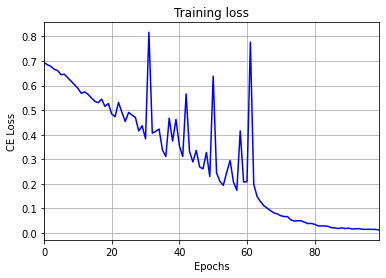

In [22]:
# plot training loss
plt.plot(loss_his, label='training loss', color='blue')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('CE Loss')
# title
plt.title('Training loss')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
#plt.legend() # add legend
plt.show()

### 5.2 Validation Loss

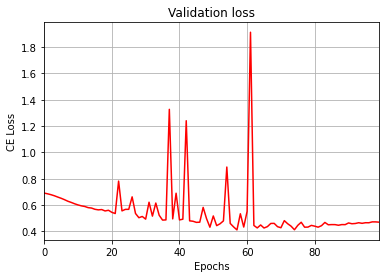

In [23]:
# plot validation loss
plt.plot(loss_val_his, label='validation loss', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('CE Loss')
# title
plt.title('Validation loss')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
#plt.legend() # add legend
plt.show()

### 5.3 Zoom at the minimum of CE loss curve

Epoch with minimum validation loss = 58


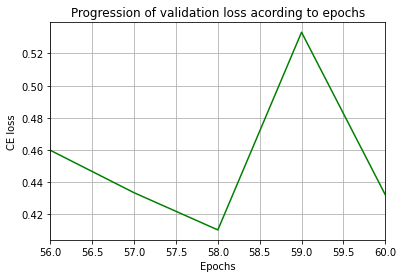

In [24]:
BEST_EPOCH = loss_val_his.index(min(loss_val_his)) + 1
print('Epoch with minimum validation loss =', BEST_EPOCH)
#-------------------------------------------------
# plots
plt.plot(range(max(1,BEST_EPOCH-2),min(EPOCH,BEST_EPOCH+3)), loss_val_his[max(1,BEST_EPOCH-3):min(EPOCH-1,BEST_EPOCH+2)], 'green')
plt.xlabel('Epochs')
plt.ylabel('CE loss')
plt.autoscale(axis='x', tight=True)
plt.title('Progression of validation loss acording to epochs')
plt.grid(True)
plt.show()

### 5.4 Print the final values of the main training monitoring variables:
- loss function final value:
- metrics final values:

In [25]:
print('last training loss = {0:.4f}'.format(loss_his[-1]))
print('last validation loss = {0:.4f}'.format(loss_val_his[-1]))
#-------------------------------------------------
print('#-------------------------------------------------')
print('last train accuracy = {0:.4f}'.format(acc_train.item()))
print('last validation accuracy = {0:.4f}'.format(acc_val.item()))

last training loss = 0.0127
last validation loss = 0.4693
#-------------------------------------------------
last train accuracy = 1.0000
last validation accuracy = 0.7700


## 6. Final training

In [26]:
print('Train until epoch:', BEST_EPOCH)

Train until epoch: 58


### 6.1 Merge training and validation datasets

In [0]:
ds_final = ds_train + ds_val

### 6.2 PyTorch DataLoader

In [0]:
dl_final  = torch.utils.data.DataLoader(
            dataset = ds_final,
            drop_last = False,
            shuffle = False,
            batch_size = BATCH_SIZE_TRAIN)

### 6.2 Early stopping

In [29]:
loss_final = []
N_SAMPLES = len(ds_train)
for epoch in range(BEST_EPOCH):
    print('epoch =', epoch, end='; ')
    #-------------------------------------------------
    # training mode
    #-------------------
    model.train()
    score_final = 0.
    for b_i, (b_x, b_y) in enumerate(dl_final):
        b_x, b_y = b_x.to(device), b_y.to(device)
        y_logitos = model(b_x)
        loss = loss_func(y_logitos, b_y)
        opt.zero_grad()                 # clear gradients for next train
        loss.backward()                 # backpropagation, compute gradients
        opt.step()                      # apply gradients
        #-------------------
        y_pred = torch.argmax(y_logitos, dim=1)
        score_final += (b_y == y_pred).sum()
    acc_final = score_final / N_SAMPLES
    loss_final.append(loss.item())            # trainint loss history
    acc_final = score_final / len(ds_final)
    #-------------------------------------------------
    print('loss_final = {0:.4f}'.format(loss_final[-1]), end='; ')
    print('acc_final = {0:.4f}'.format(acc_final), end='\n')

epoch = 0; loss_final = 0.5341; acc_final = 0.9387
epoch = 1; loss_final = 0.6176; acc_final = 0.7462
epoch = 2; loss_final = 0.3925; acc_final = 0.8450
epoch = 3; loss_final = 0.4924; acc_final = 0.8438
epoch = 4; loss_final = 0.3775; acc_final = 0.8413
epoch = 5; loss_final = 0.5827; acc_final = 0.8375
epoch = 6; loss_final = 0.3001; acc_final = 0.8850
epoch = 7; loss_final = 0.3618; acc_final = 0.8462
epoch = 8; loss_final = 0.2797; acc_final = 0.9688
epoch = 9; loss_final = 0.3688; acc_final = 0.8425
epoch = 10; loss_final = 0.5641; acc_final = 0.9450
epoch = 11; loss_final = 0.3811; acc_final = 0.8650
epoch = 12; loss_final = 0.4414; acc_final = 0.8462
epoch = 13; loss_final = 0.2466; acc_final = 0.9162
epoch = 14; loss_final = 0.1703; acc_final = 0.9862
epoch = 15; loss_final = 0.1548; acc_final = 0.9850
epoch = 16; loss_final = 0.2627; acc_final = 0.9800
epoch = 17; loss_final = 0.3193; acc_final = 0.8175
epoch = 18; loss_final = 0.2074; acc_final = 0.9712
epoch = 19; loss_final

## 7. Metrics on test set

### 7.1 Accuracy

In [30]:
# load model in CPU
model.to('cpu');
# evaluation mode
model.eval()

NN(
  (L1): Linear(in_features=18668, out_features=10000, bias=True)
  (L1D): Dropout(p=0.5, inplace=False)
  (L2): Linear(in_features=10000, out_features=1000, bias=True)
  (L2D): Dropout(p=0.5, inplace=False)
  (L3): Linear(in_features=1000, out_features=2, bias=True)
)

In [0]:
# y_true
y_true = ds_test[:][1]

In [0]:
# y_pred
score = 0.
y_logitos = model(ds_test[:][0])
y_pred = torch.argmax(y_logitos, dim=1)

In [33]:
# accuracy
score += (y_true == y_pred).sum()
acc_test = score / len(ds_test[:][0])
acc_test.item()

0.8149999976158142

### 7.2 Confusion matrix

In [0]:
cm = confusion_matrix(y_true, y_pred)
classes = enc.get_feature_names()

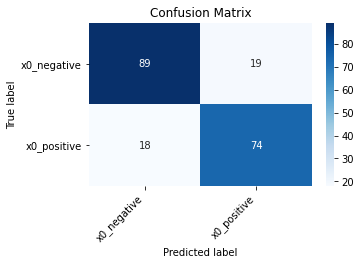

In [35]:
# CM raw
cm_raw = print_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=False, cmap=plt.cm.Blues, fontsize=10, figsize = (5,3))

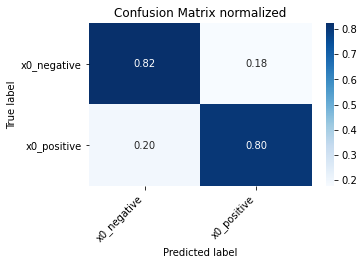

In [36]:
# CM normalized
cm_norm = print_confusion_matrix(cm, classes, title='Confusion Matrix normalized', normalize=True, cmap=plt.cm.Blues, fontsize=10, figsize = (5,3))

### 7.3 F1-score (macro, micro and weighted)

In [0]:
macro = f1_score(y_true, y_pred, average='macro')
micro = f1_score(y_true, y_pred, average='micro')
weighted = f1_score(y_true, y_pred, average='weighted')

In [38]:
print('F1-score macro =', macro)
print('F1-score micro =', micro)
print('F1-score weighted =', weighted)

F1-score macro = 0.813953488372093
F1-score micro = 0.815
F1-score weighted = 0.8150697674418604


### 7.4 Accuracy and Precision

In [0]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')

In [40]:
print('Accuracy score = ', acc, sep='')
print('Precision score = ', prec, sep='')

Accuracy score = 0.815
Precision score = 0.8137373128328811


### 7.5 Precision, Recall and F1-Score for each class

In [41]:
from sklearn.metrics import classification_report as cr
print(cr(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       108
           1       0.80      0.80      0.80        92

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.82      0.81      0.82       200



## End of the notebook